In [199]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np

In [200]:
# n_examples = 5000
# model = "Standard"
# attack = "UPGD"
# norm = "Linf"
# epsilon = "255_8"
# iterations = 2
# restarts = 1
# alpha = "0_01"
# rand_init = True



# attack_dir = f"results/cifar10/n_examples_{n_examples}/model_{model}/attack_{attack}/norm_{norm}_eps_from_{epsilon}_iter_{iterations}_restarts_{restarts}_alpha_{alpha}_rand_init_{rand_init}"

In [201]:
# # load perturbations from perturbations directory under attack_dir
# perturbations_dir = os.path.join(attack_dir, "perturbations")
# # under one file named adv_input.pt
# perturbations = torch.load(os.path.join(perturbations_dir, "adv_input.pt"))
# universal_perturbation = torch.load(os.path.join(perturbations_dir, "universal_pert.pt"))

In [202]:
# # sample and present some perturbations (perturbations.shape = torch.Size([500, 3, 32, 32]))
# # and the universal perturbation (universal_perturbation.shape = torch.Size([3, 32, 32]))
# n_samples = 5
# sample_indices = np.random.choice(n_examples, n_samples, replace=False)
# fig = plt.figure(figsize=(15, 8))

# # Create the subplots for sampled images (first row)
# for i, idx in enumerate(sample_indices):
#     ax = fig.add_subplot(2, n_samples, i + 1)
#     ax.imshow(perturbations[idx].cpu().permute(1, 2, 0).numpy())
#     ax.axis("off")
#     ax.set_title(f"Sample {idx}")

# # Create a single subplot for the universal perturbation (second row, spanning all columns)
# ax_universal = fig.add_subplot(2, 1, 2)
# ax_universal.imshow(universal_perturbation.cpu().permute(1, 2, 0).numpy()*100)
# ax_universal.axis("off")
# ax_universal.set_title("Universal Perturbation")

# # Adjust the layout for clarity
# plt.tight_layout()
# plt.show()

# Check Real Results

In [203]:
results_dir = "results/cifar10/n_examples_10000"
standard_dir = os.path.join(results_dir, "model_Standard")
better_dir = os.path.join(results_dir, "model_Wang2023Better_WRN-28-10")
fast_dir = os.path.join(results_dir, "model_Wong2020Fast")


def load_results(model_dir):
    # first, go to each attack directory and load the results
    attack_dirs = os.listdir(model_dir)
    results = {}
    for attack_dir in attack_dirs:
        if "Stochastic" in attack_dir:
            continue
        exp_dirs = os.listdir(os.path.join(model_dir, attack_dir))
        for exp_dir in exp_dirs:
            pert_dir = os.path.join(model_dir, attack_dir, exp_dir, "perturbations")
            if os.path.exists(os.path.join(pert_dir, "adv_input.pt")):
                perturbations = torch.load(os.path.join(pert_dir, "adv_input.pt"))
                universal_perturbation = torch.load(os.path.join(pert_dir, "universal_pert.pt"))
                mean_loss_per_step = torch.load(os.path.join(pert_dir, "mean_loss_per_step.pt"))
                yaniv_accuracy = torch.load(os.path.join(pert_dir, "yaniv_accuracy.pt"))
                results[pert_dir] = (perturbations, universal_perturbation, mean_loss_per_step, yaniv_accuracy)
    return results


standard_results = load_results(standard_dir)
better_results = load_results(better_dir)
fast_results = load_results(fast_dir)

/tmp/ipykernel_430859/3382504749.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  perturbations = torch.load(os.path.join(pert_dir, "adv_input.pt"))
/tmp/ipykernel_43085

Best ASR for Standard Model: attack_FourierUPGD_batch_size_128_threshold_0_7 (Final ASR: 81.90)


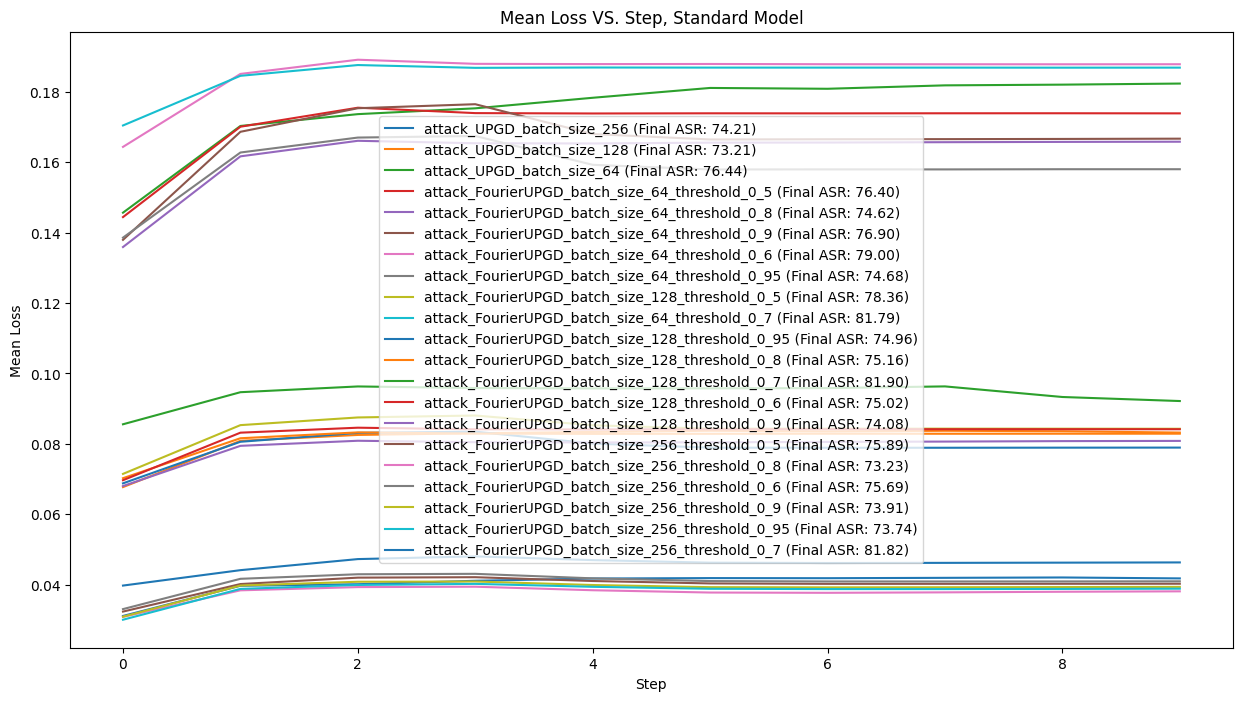

Best ASR for Better Model: attack_FourierUPGD_batch_size_256_threshold_0_95 (Final ASR: 1.10)


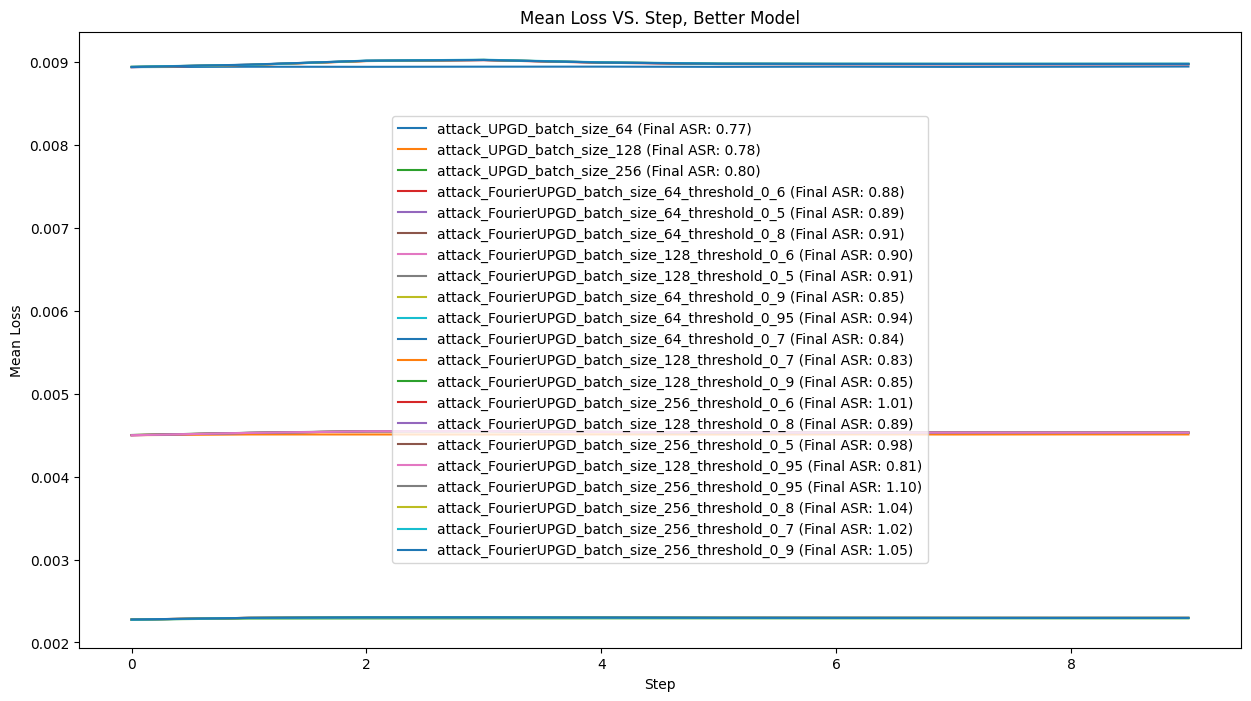

Best ASR for Fast Model: attack_FourierUPGD_batch_size_256_threshold_0_95 (Final ASR: 1.91)


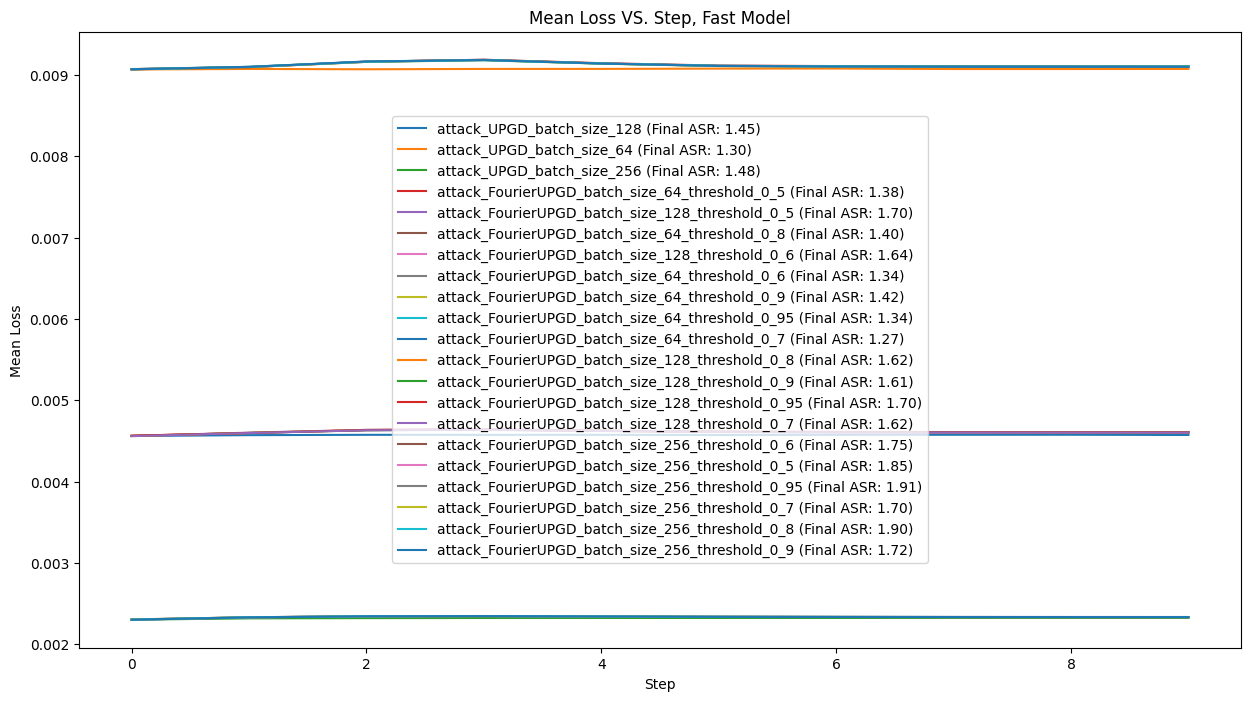

In [204]:
def plot_mean_loss_per_step(results, model_name):
    # plot the mean loss per step for each attack in the same plot to compare them
    fig = plt.figure(figsize=(15, 8))
    best_asr = 0
    best_asr_label = ""
    for pert_dir, (_, _, mean_loss_per_step, yaniv_accuracy) in results.items():
        checked_params = pert_dir.split("/")[-2].split("_")[16:]
        # to string
        checked_params = "_".join(checked_params)
        label = pert_dir.split("/")[-3] + "_" + checked_params + f" (Final ASR: {yaniv_accuracy:.2f})"
        if yaniv_accuracy > best_asr:
            best_asr = yaniv_accuracy
            best_asr_label = label
        plt.plot(mean_loss_per_step, label=label)
    print(f"Best ASR for {model_name}: {best_asr_label}")
    plt.title(f"Mean Loss VS. Step, {model_name}")
    plt.xlabel("Step")
    plt.ylabel("Mean Loss")
    plt.legend()
    plt.show()


plot_mean_loss_per_step(standard_results, "Standard Model")
plot_mean_loss_per_step(better_results, "Better Model")
plot_mean_loss_per_step(fast_results, "Fast Model")

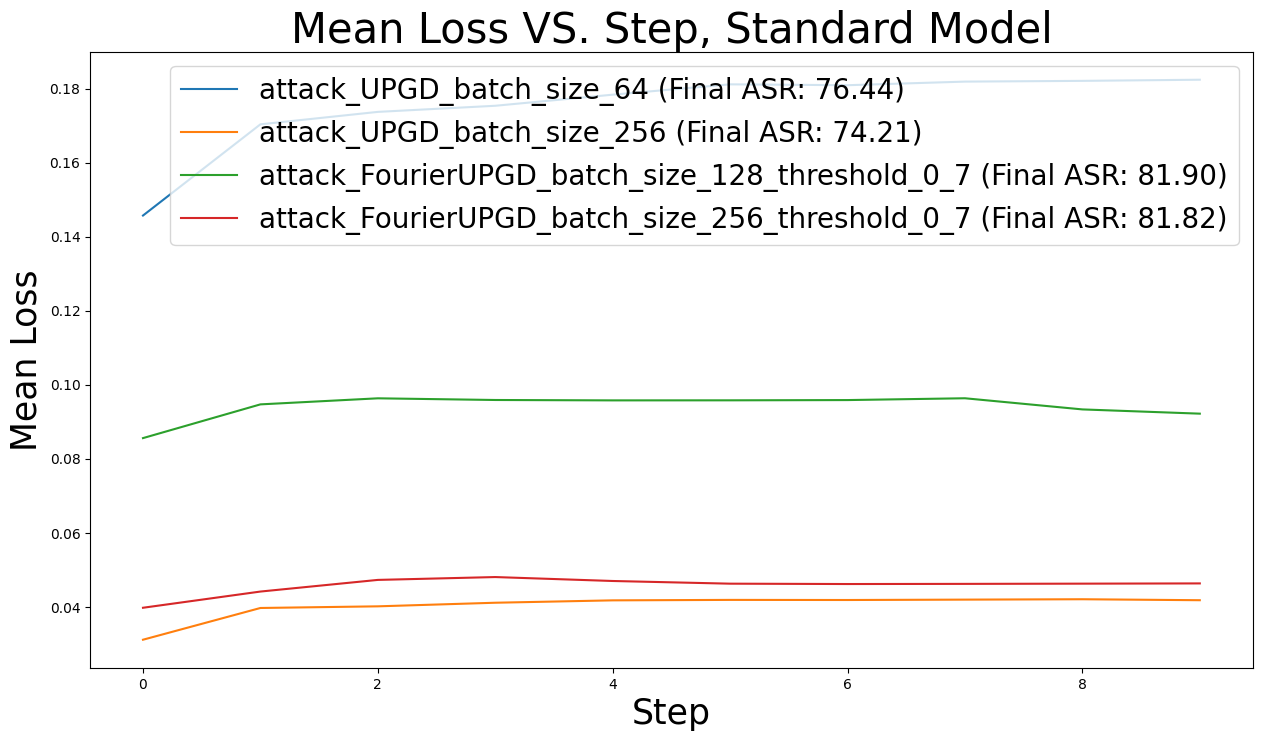

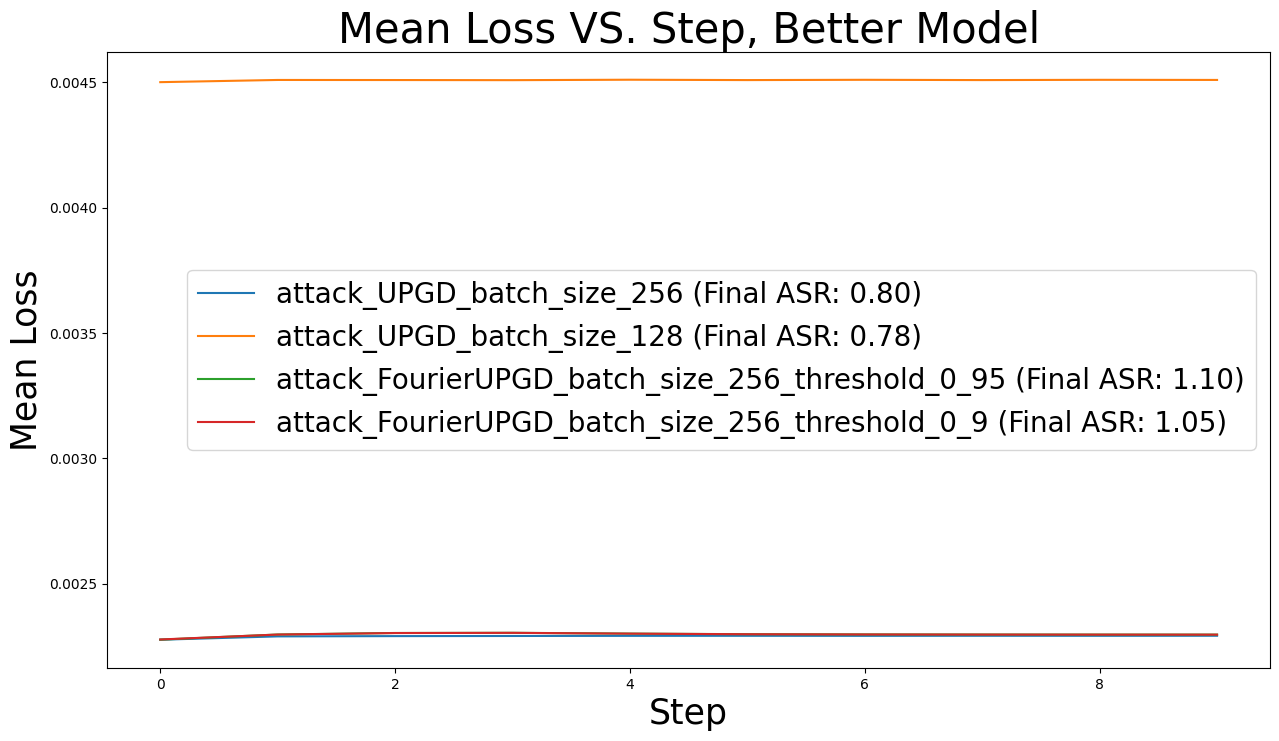

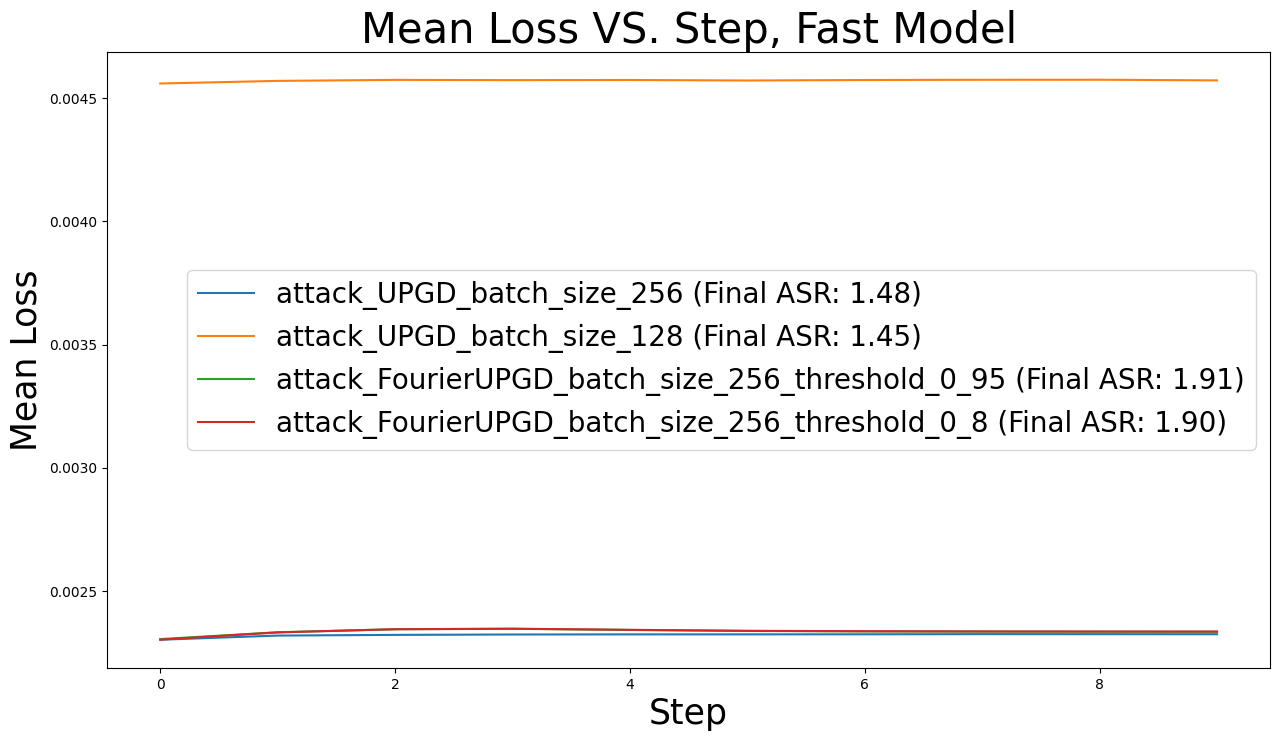

In [223]:
def plot_top_k_mean_loss_per_step(results, model_name, k=2):
    # plot the mean loss per step for each attack in the same plot to compare them
    # plot only the top k in each attack (by ASR)
    fig = plt.figure(figsize=(15, 8))
    attack_asrs = {}
    for pert_dir, (_, _, mean_loss_per_step, yaniv_accuracy) in results.items():
        checked_params = pert_dir.split("/")[-2].split("_")[16:]
        # to string
        checked_params = "_".join(checked_params)
        label = pert_dir.split("/")[-3] + "_" + checked_params + f" (Final ASR: {yaniv_accuracy:.2f})"
        attack_name = pert_dir.split("/")[4]
        if attack_name not in attack_asrs:
            attack_asrs[attack_name] = []
        attack_asrs[attack_name].append((mean_loss_per_step, yaniv_accuracy, label))
    for attack_name, attack_results in attack_asrs.items():
        attack_results.sort(key=lambda x: x[1], reverse=True)
        for i, (mean_loss_per_step, yaniv_accuracy, label) in enumerate(attack_results[:k]):
            plt.plot(mean_loss_per_step, label=label)
    plt.title(f"Mean Loss VS. Step, {model_name}", fontsize=30)
    plt.xlabel("Step", fontsize=25)
    plt.ylabel("Mean Loss", fontsize=25)
    # make the legend bigger
    plt.legend(prop={'size': 20})
    plt.show()

plot_top_k_mean_loss_per_step(standard_results, "Standard Model")
plot_top_k_mean_loss_per_step(better_results, "Better Model")
plot_top_k_mean_loss_per_step(fast_results, "Fast Model")

In [215]:
def barplot_mean_loss_per_batch_size(results, model_name, show_loss=True):
    # plot the mean loss per step for each attack in the same plot to compare them
    fig = plt.figure(figsize=(15, 8))
    batch_size_results_dict = {}

    for pert_dir, (_, _, mean_loss_per_step, yaniv_accuracy) in results.items():
        batch_size = pert_dir.split("/")[-2].split("_")[18]
        if batch_size not in batch_size_results_dict:
            batch_size_results_dict[batch_size] = []
        if show_loss:
            batch_size_results_dict[batch_size].append(mean_loss_per_step[-1])
        else:
            batch_size_results_dict[batch_size].append(yaniv_accuracy)

    batch_sizes = list(batch_size_results_dict.keys())
    # sort by int of batch size
    batch_sizes = sorted(batch_sizes, key=lambda x: int(x))

    mean_asrs = [np.mean(batch_size_results_dict[batch_size]) for batch_size in batch_sizes]
    std_asrs = [np.std(batch_size_results_dict[batch_size]) for batch_size in batch_sizes]

    plt.bar(batch_sizes, mean_asrs, yerr=std_asrs, capsize=5)
    if show_loss:
        plt.title(f"Mean Loss VS. Batch Size, {model_name}")
        plt.ylabel("Mean Loss")
    else:
        plt.title(f"Mean ASR VS. Batch Size, {model_name}")
        plt.ylabel("Mean ASR")
    plt.show()

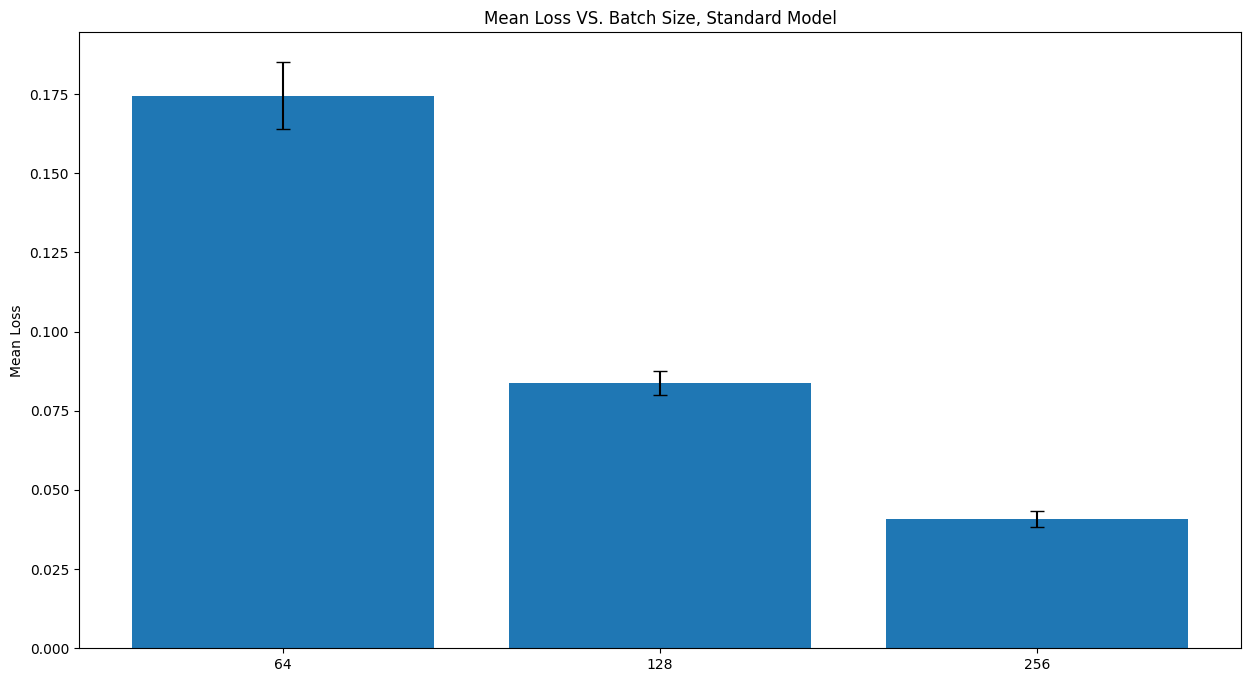

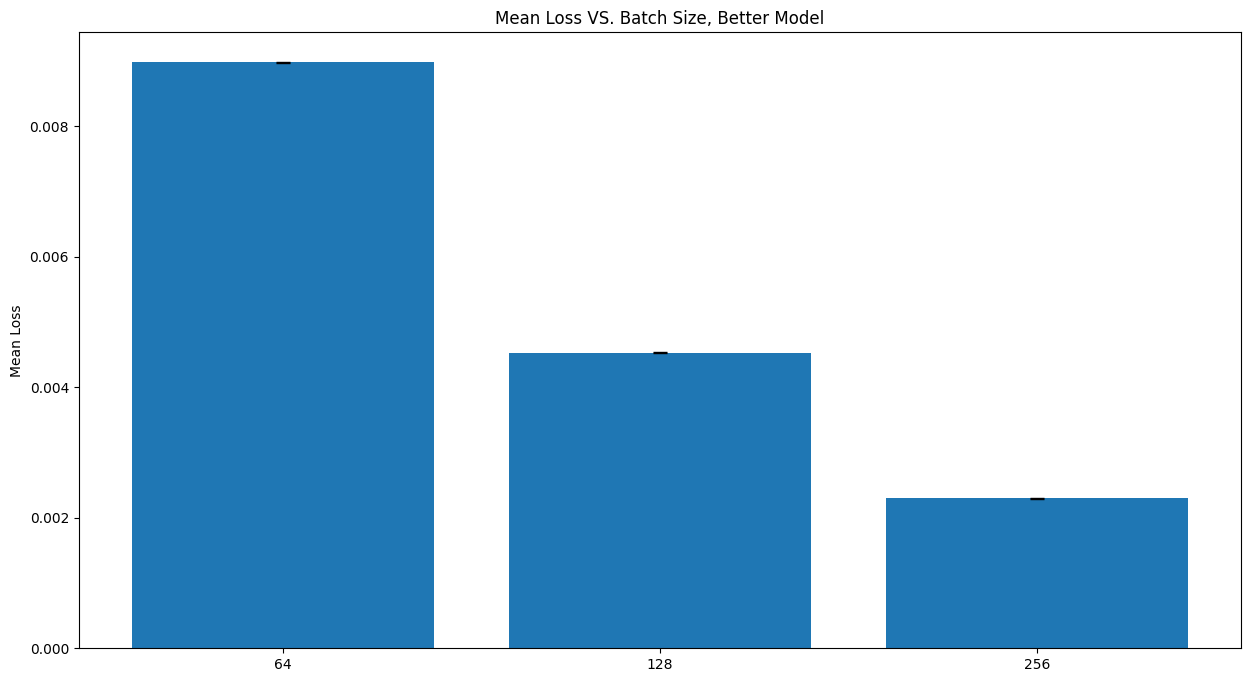

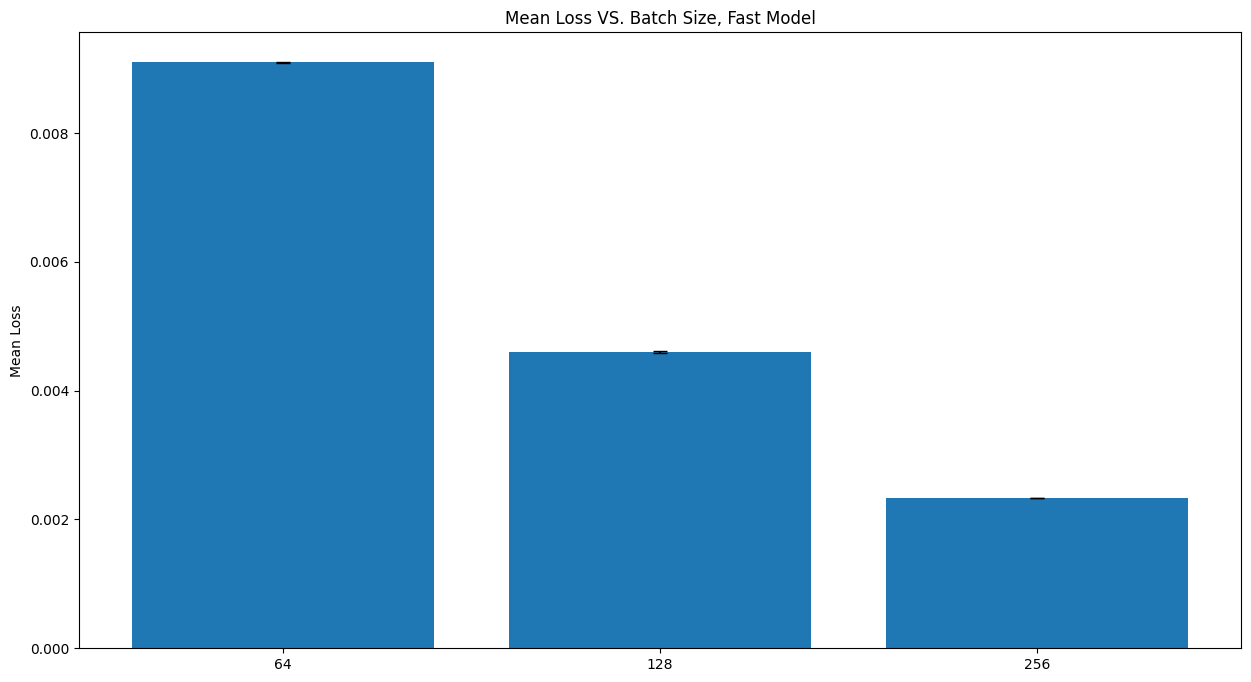

In [216]:
barplot_mean_loss_per_batch_size(standard_results, "Standard Model", show_loss=True)
barplot_mean_loss_per_batch_size(better_results, "Better Model", show_loss=True)
barplot_mean_loss_per_batch_size(fast_results, "Fast Model", show_loss=True)

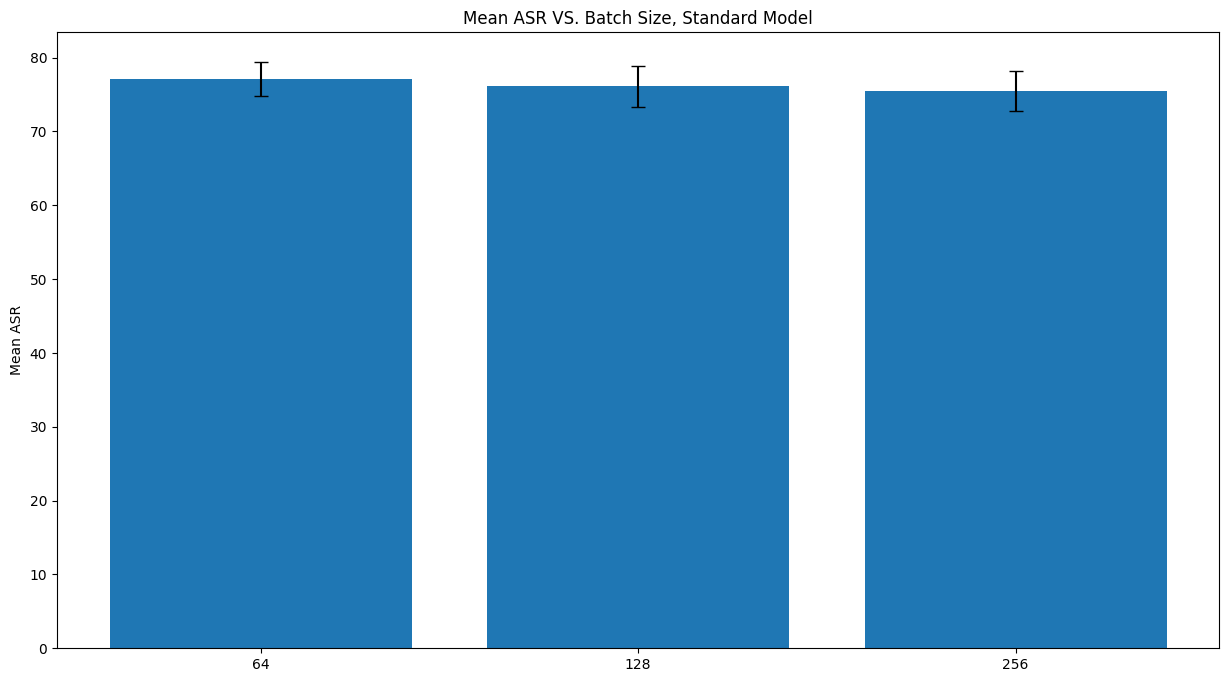

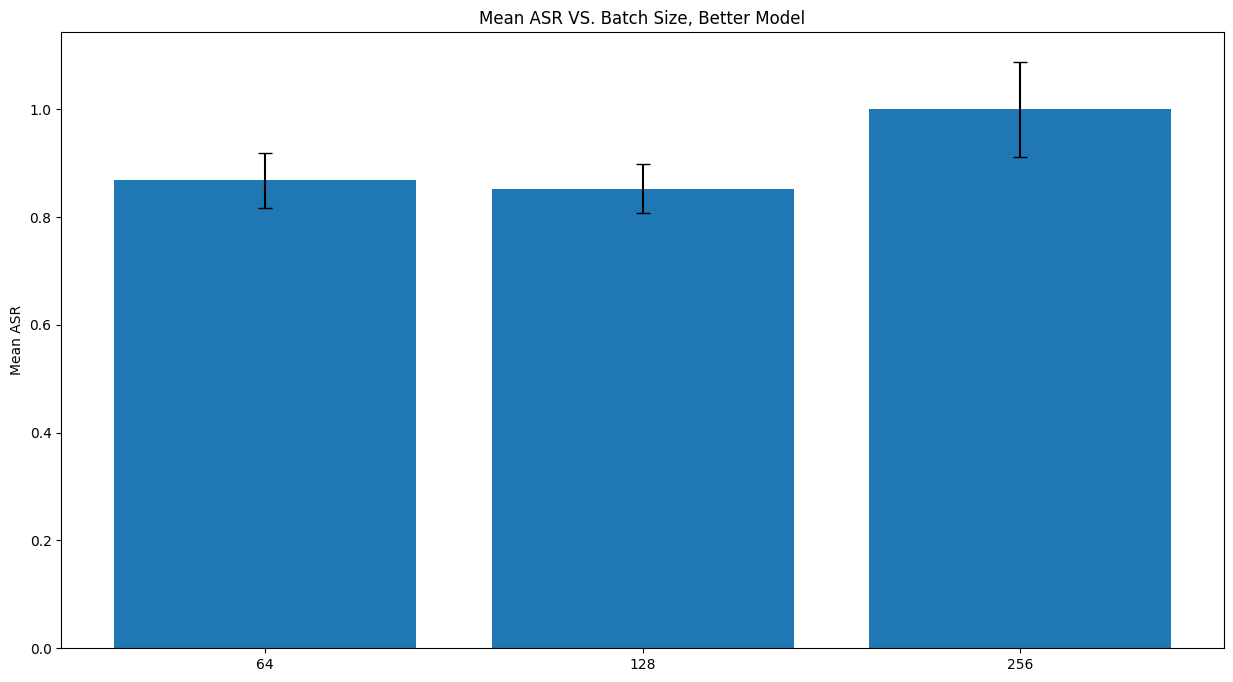

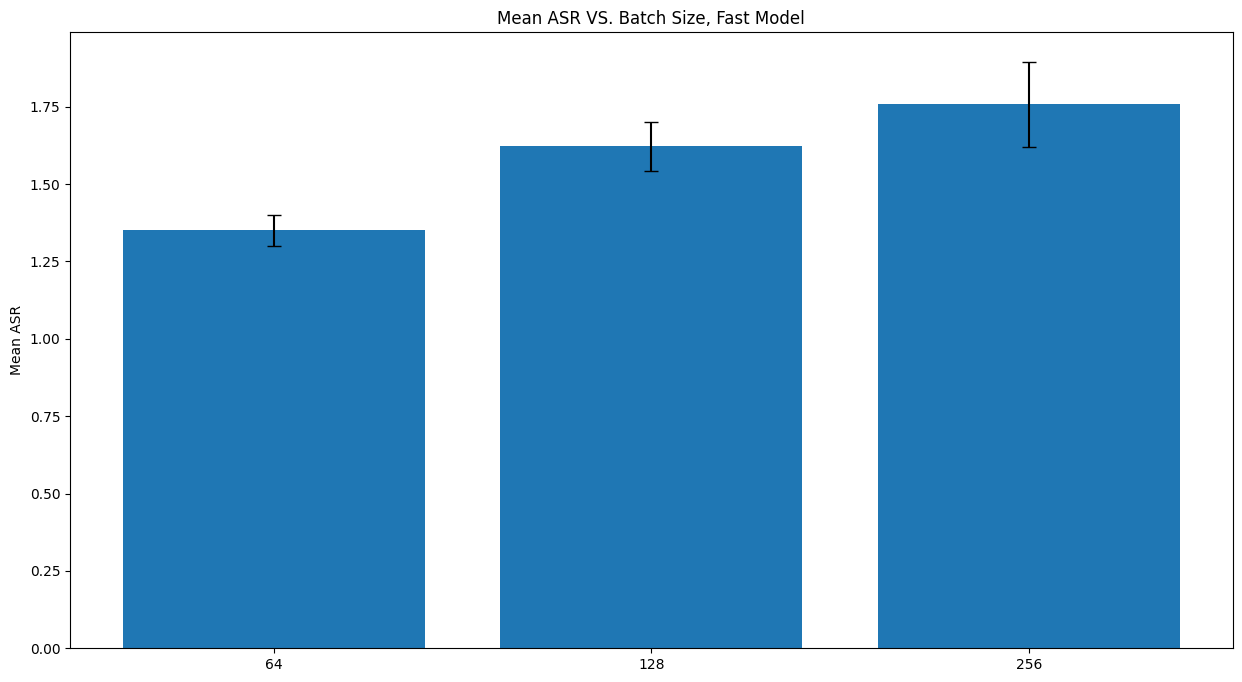

In [217]:
barplot_mean_loss_per_batch_size(standard_results, "Standard Model", show_loss=False)
barplot_mean_loss_per_batch_size(better_results, "Better Model", show_loss=False)
barplot_mean_loss_per_batch_size(fast_results, "Fast Model", show_loss=False)